<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
try:
    data = pd.read_csv('/Users/Даня/Downloads/taxi.csv',parse_dates=[0],index_col=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0],index_col=[0])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

In [ ]:
data.index.is_monotonic

True

In [ ]:
data = data.resample('1H').sum()

**Вывод**: у нас есть информмация с 1 марта 2018 года, по 31 августа 2018 года, в которых отсутсвюут пропуски. Более того, мы сделали ресемплирование по одному часу

## Анализ

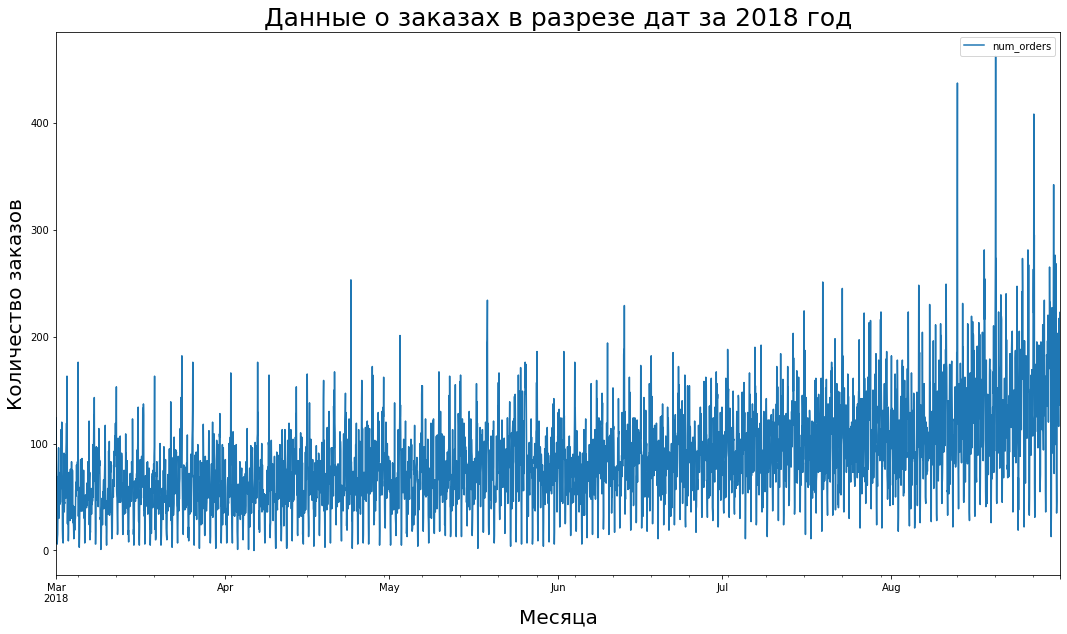

In [ ]:
plt.rc('axes', titlesize= 25,labelsize= 20)
data.plot(figsize=(18,10))
plt.title('Данные о заказах в разрезе дат за 2018 год')
plt.ylabel('Количество заказов')
plt.xlabel('Месяца')
plt.show()

**Скользящее среднее**

In [ ]:
data_1 = data.copy()
data_1 = data - data_1.shift()

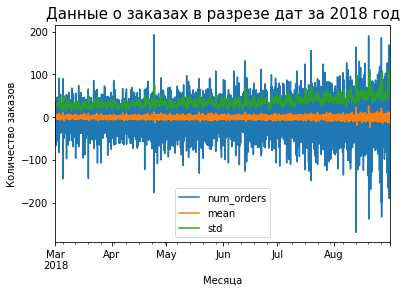

In [ ]:
plt.rc('axes', titlesize= 15,labelsize= 10)
data_1['mean'] = data_1['num_orders'].rolling(15).mean()
data_1['std'] = data_1['num_orders'].rolling(15).std()
data_1.plot()
plt.title('Данные о заказах в разрезе дат за 2018 год')
plt.ylabel('Количество заказов')
plt.xlabel('Месяца')
plt.show()

**Тренды и сезонность**

In [ ]:
decomposed = seasonal_decompose(data)

Text(0.5, 0, 'Месяца')

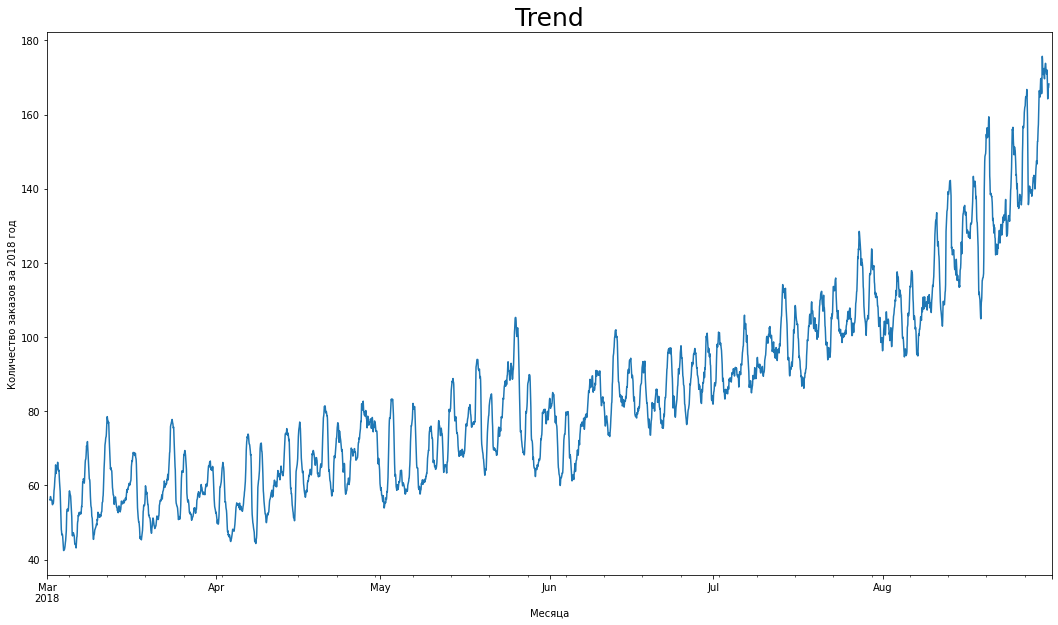

In [ ]:
plt.rc('axes', titlesize= 25,labelsize= 10)
plt.figure(figsize=(18, 10))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Количество заказов за 2018 год')
plt.xlabel('Месяца')

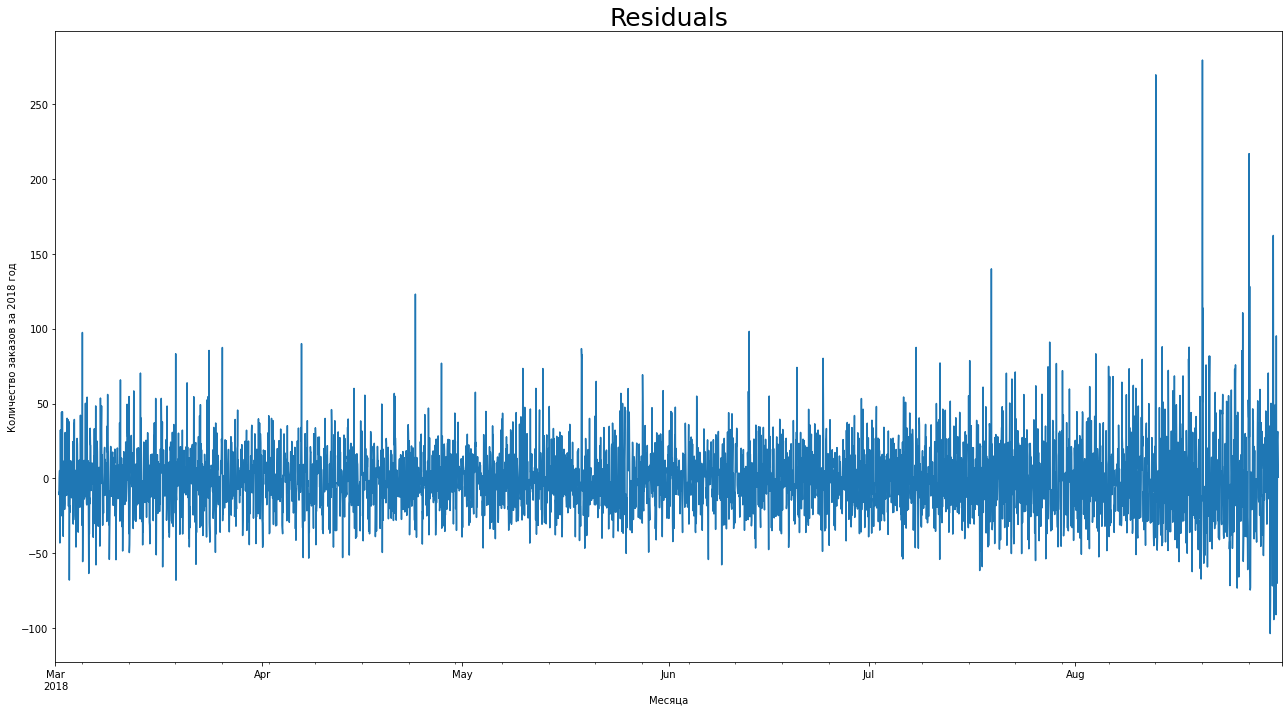

In [ ]:
plt.figure(figsize=(18, 10))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Количество заказов за 2018 год')
plt.xlabel('Месяца')
plt.tight_layout()

Рассмотрим данные сезонные за последнюю неделю августа

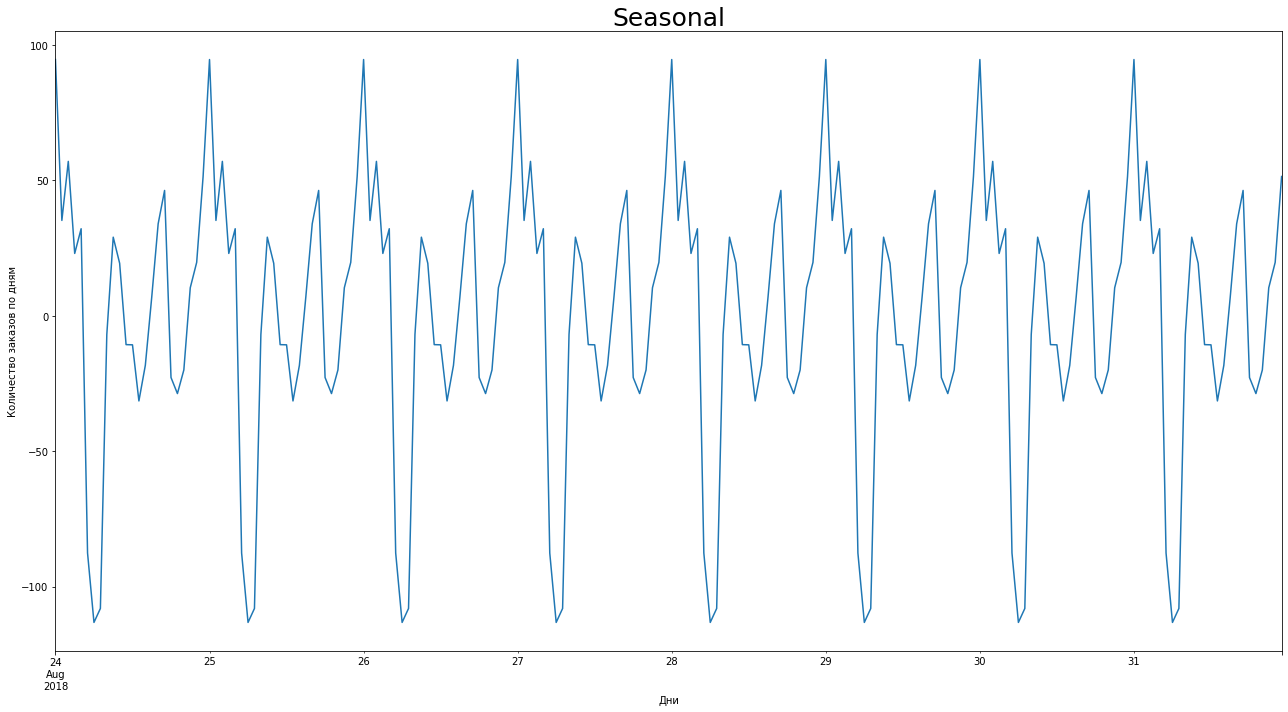

In [ ]:
decomposed_data = seasonal_decompose(data['2018-08-24':'2018-08-31'])
decomposed_data.seasonal.plot(figsize=(18, 10))
plt.title('Seasonal')
plt.ylabel('Количество заказов по дням')
plt.xlabel('Дни')
plt.tight_layout()

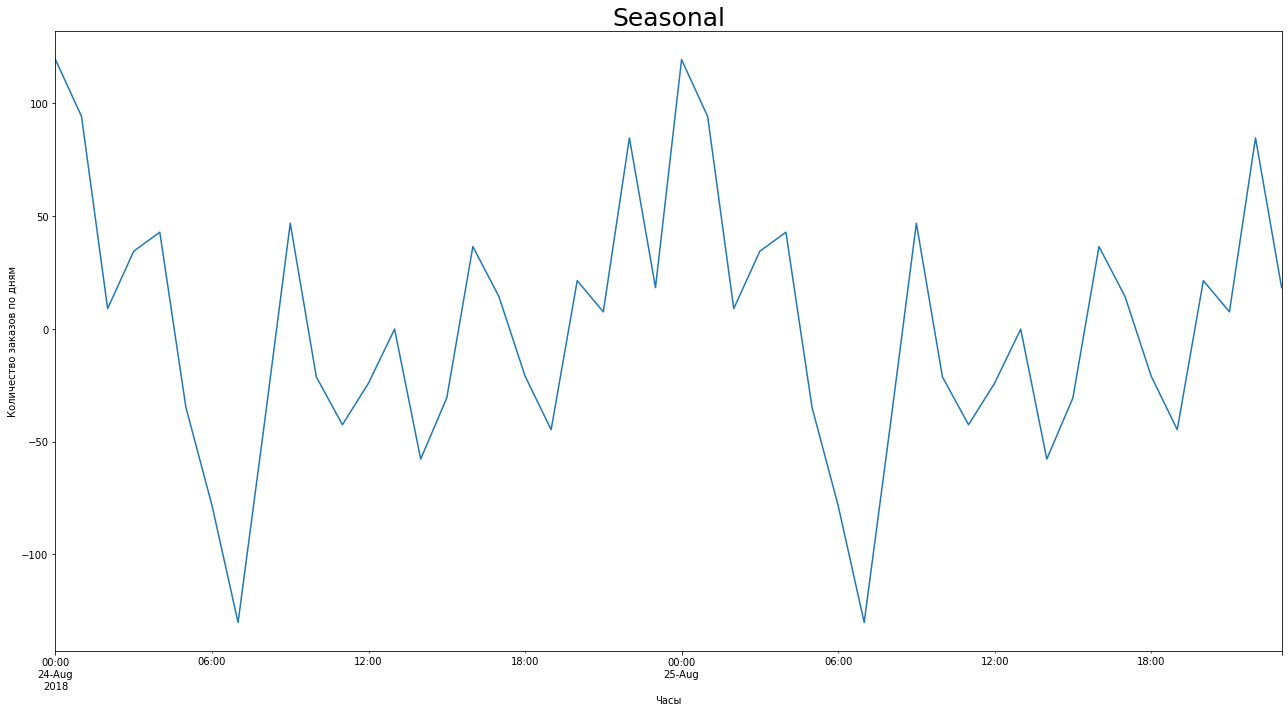

In [ ]:
decomposed_data = seasonal_decompose(data['2018-08-24':'2018-08-25'].resample('1H').sum())
decomposed_data.seasonal.plot(figsize=(18, 10))
plt.title('Seasonal')
plt.ylabel('Количество заказов по дням')
plt.xlabel('Часы')
plt.tight_layout()

**Вывод:**
- Тренд восходящий, растет количество пользователей и заказов растет от месяца к месяцу
- Благодаря графику сезонности мы видим, что количество пользователей растет вечером(самый пик в 00-00), а затем утром убывает(отмечается точка минимума)
- Временной ряд в не является стационарным

## Обучение

**Создадим признаки**

In [ ]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

**Разделим на выборки**

In [ ]:
make_features(data,'num_orders', 25, 1)
train, tmp = train_test_split(data, shuffle=False, test_size=0.2)
valida, test = train_test_split(tmp, shuffle=False, test_size=0.5)
train = train.dropna()

**Проверим размеры**

In [ ]:
test.shape,data.shape

In [ ]:
features_train = train.drop('num_orders',axis = 1)
features_test = test.drop('num_orders',axis = 1)
features_valida = valida.drop('num_orders',axis = 1)

In [ ]:
target_train = train['num_orders']
target_test = test['num_orders']
target_valida = valida['num_orders']

**"Случаный лес"**

In [ ]:
for depth in range(1,10):
    for est in range(5,10,5):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=1234)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valida)
        rmse = mean_squared_error(target_valida, predictions)**0.5
        print('Количество деревьев:', est, "Глубина",depth)
        print('RMSE для случайного леса:', rmse)
        print('')

**Модель решающего дерева**

In [ ]:
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valida)
    rmse = mean_squared_error(target_valida, predictions)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse)
    print('')

**Линейная регрессия**

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valida)
rmse = mean_squared_error(target_valida, predictions)**0.5
print('RMSE для линейной регресии:', rmse)

**Вывод**: Лучше всего себя показала модель линейной регрессии, где значение rmse = 34. На втором месте случайный лес с rmse 35. На последнем месте решающее дерево с результатом 39.

## Тестирование

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print(rmse)

**Вывод**: Удалось достигнуть RMSE ниже 48 на тестовой выборке.

# Итоговый вывод

На начальном этапе мы загрузили данные, где изменили временной формат. Мы получили данные с 1 марта 2018 года, по 31 августа 2018 года и сделали ресемплирование по одному часу. Далее мы сделали анализ данных и выяснили, что количество клиентов растет с каждым месяцем, а также люди заказывают такси чаще в 00-00.
Более того, мы выделили целевой признак и разделили данные по выборкам для обучения моделей: случайный лес, решающего дерева, линейная регрессия. По результатам обучения были выявлены следующие метрики: лучше всего себя показала модель линейной регрессии, где значение rmse = 34; на втором месте случайный лес с rmse 35; На последнем месте решающее дерево с результатом 39.
Именно поэтому была выбрана модель линейной регрессии, где в результате тестирования получили rmse меньше 48, а именно 46